# Context View Out Notebook

## 0. Initialization

### 0.1. Importing libraries and setting global variables

In [1]:
import EN_17037_Recipes as enr 
import pyvista as pv
import os
import pandas as pd
import numpy as np
import trimesh as tm
import itertools
import matplotlib.pyplot as plt

cwd = os.getcwd()
src = os.path.dirname(cwd)

Path to radiance is set to: /usr/local/radiance
Path to perl is set to: /usr/bin


### 0.2. Setting global variables

In [2]:
point_grid_height = "1_7"
project_name = 'EN_17037_context_view_' + point_grid_height
# create the material dictionary
material_dict = {
    "material_plastic": enr.material_plastic,
    "material_glass": enr.material_glass
}

# load the surface information table
surface_df = pd.read_csv("cv_file_table.csv")
surface_df

,surface_name,surface_type,file_path,material_name
0,wall,0,ref_room_walls.obj,material_plastic
1,context_buildings,0,test_context_01_buildings.obj,material_plastic
2,context_ground,0,test_context_01_ground.obj,material_plastic


### 0.3. Prepare Analysis Information

In [3]:
# homogenous discretization of sphere
icosphere = tm.creation.icosphere(subdivisions=4, radius=1.0)
v = icosphere.vertices

# setting the rays and points
rays = [tuple(v) for v in icosphere.vertices]
grid_path = os.path.join(src, "data", "point_grid_view_" + point_grid_height + ".csv")
grid_array = np.genfromtxt(grid_path, delimiter=",")
pnts = [tuple(pnt) for pnt in grid_array]

# generate grid of test points
test_inds = [j for j in range(len(pnts)) for i in range(len(rays))]
test_pnts = [pnt for pnt in pnts for i in range(len(rays))]
test_rays = rays * len(pnts)

## 1. Simulation

### 1.1. Importing geometries and assigning materials

In [4]:
# loading all meshes and converting them into hb surfaces
hb_surfaces = []
for _, srf in surface_df.iterrows():
    filepath = os.path.join(src, "data", srf["file_path"])
    mesh = pv.read(filepath)
    hb_surf = enr.pv_mesh_to_hbsurface(mesh, srf["surface_type"], srf["surface_name"], material_dict[srf["material_name"]])
    hb_surfaces.extend(hb_surf)

### 1.2. Create Recipe

In [5]:
analysis_grid = enr.AnalysisGrid.from_points_and_vectors(test_pnts, test_rays, 'test_grid')

# put the recipe together
rp = enr.ContextViewGridBased(analysis_grids=(analysis_grid,),
               hb_objects=hb_surfaces)

Found 12170 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.


### 1.3. Create Batch Files

In [6]:
# write simulation to folder
batch_file = rp.write(
    target_folder='.', project_name=project_name)

Writing recipe contents to: ./EN_17037_context_view_1_7/gridbased


### 1.4. Run the simulation

In [7]:
# run the simulation
rp.run(batch_file, debug=False)

True

## 2. Results

### 2.1. Load and parse the results

In [8]:
# load grid data
grid_df = pd.read_csv(grid_path, skiprows=0, sep=',', header=None, names=['Sx','Sy','Sz'])

# load rtrace results
rs_path = os.path.join(project_name, 'gridbased', 'rtrace_res.txt')
rtrace_res = pd.read_csv(rs_path, skiprows=8, sep='\t', usecols=[3,4,5], header=None, names=['last_int_name', 'first_int_dist', 'last_int_dist'])
rtrace_res.replace("*", "sky", inplace=True)
# load the rays
rays_path = os.path.join(project_name, 'gridbased', project_name + '.pts')
rays_df = pd.read_csv(rays_path, skiprows=0, sep=' ', header=None, names=['Sx','Sy','Sz','Rx', 'Ry', 'Rz'])
print(rays_df.shape)
# concatenate data frames and group by point ids
grid_results = pd.concat([rays_df, rtrace_res], axis = 1)

# create masks
grid_results['window_mask'] = grid_results['last_int_name'] != "wall"
grid_results['horizon_mask'] = grid_results['Rz'].abs() < 0.01
grid_results['hw_mask'] = grid_results['window_mask'] * grid_results['horizon_mask']

#create groupby
gb = grid_results.groupby(test_inds)

(3586800, 6)


### 2.2. Compute window view solid angle on each grid point

In [9]:
# window view solid angle in steradian
grid_df["window_solid_angle"] = 4 * np.pi * gb['window_mask'].sum() / len(rays)
grid_df

,Sx,Sy,Sz,window_solid_angle
0,-36.3025,36.3396,11.0,0.495396
1,-36.1745,36.3925,11.0,1.226227
2,-36.0464,36.4454,11.0,2.457358
3,-35.9184,36.4983,11.0,3.090091
4,-35.7903,36.5511,11.0,3.443244
...,...,...,...,...
1395,-36.7611,44.7090,11.0,0.063764
1396,-36.6331,44.7618,11.0,0.063764
1397,-36.5050,44.8147,11.0,0.073574
1398,-36.3770,44.8676,11.0,0.063764


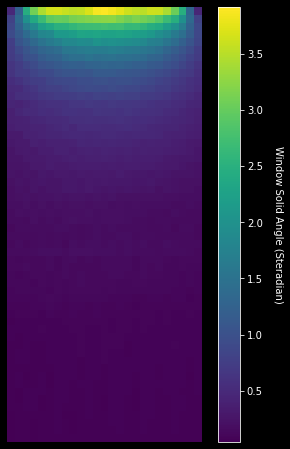

In [53]:
plt.figure(figsize = (6,8))
plt.imshow(grid_df["window_solid_angle"].to_numpy().reshape((-1, 25)))

plt.axis('off')
cbar = plt.colorbar() 
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Window Solid Angle (Steradian)', rotation=270, ha='center', va='center')  

plot_path = os.path.join('plots', project_name + '_window_solid_angle.eps')
plt.savefig(plot_path, format='eps')
plt.show()

### 2.3. Compute window view horizontal angle on each grid point

In [11]:
grid_df["horizontal_angle"] = 2 * np.pi * gb['hw_mask'].sum() / gb['horizon_mask'].sum()
grid_df

,Sx,Sy,Sz,window_solid_angle,horizontal_angle
0,-36.3025,36.3396,11.0,0.495396,0.392699
1,-36.1745,36.3925,11.0,1.226227,0.785398
2,-36.0464,36.4454,11.0,2.457358,1.570796
3,-35.9184,36.4983,11.0,3.090091,2.061670
4,-35.7903,36.5511,11.0,3.443244,2.258020
...,...,...,...,...,...
1395,-36.7611,44.7090,11.0,0.063764,0.490874
1396,-36.6331,44.7618,11.0,0.063764,0.490874
1397,-36.5050,44.8147,11.0,0.073574,0.490874
1398,-36.3770,44.8676,11.0,0.063764,0.490874


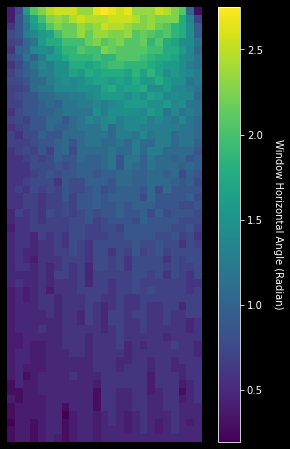

In [52]:
plt.figure(figsize = (6,8))
plt.imshow(grid_df["horizontal_angle"].to_numpy().reshape((-1, 25)))

plt.axis('off')
cbar = plt.colorbar() 
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Window Horizontal Angle (Radian)', rotation=270, ha='center', va='center')          

plot_path = os.path.join('plots', project_name + '_horizontal_angle.eps')
plt.savefig(plot_path, format='eps')
plt.show()

### 2.4. Compute view layer count on each grid point

In [13]:
counts_df = gb['last_int_name'].value_counts()

count_dict = counts_df.to_dict()
new_dict = {}
for key, val in count_dict.items():
    if key[0] in new_dict.keys():
        new_dict[key[0]][key[1]] = val
    else:
        new_dict[key[0]] = {key[1]:val}

view_layer_count_df = pd.DataFrame.from_dict(new_dict).T.fillna(0)
grid_df = pd.concat([grid_df, view_layer_count_df], axis = 1)
grid_df

,Sx,Sy,Sz,window_solid_angle,horizontal_angle,wall,context_ground,sky,context_buildings
0,-36.3025,36.3396,11.0,0.495396,0.392699,2461,43,31,27
1,-36.1745,36.3925,11.0,1.226227,0.785398,2312,102,72,76
2,-36.0464,36.4454,11.0,2.457358,1.570796,2061,222,171,108
3,-35.9184,36.4983,11.0,3.090091,2.061670,1932,285,222,123
4,-35.7903,36.5511,11.0,3.443244,2.258020,1860,320,245,137
...,...,...,...,...,...,...,...,...,...
1395,-36.7611,44.7090,11.0,0.063764,0.490874,2549,4,4,5
1396,-36.6331,44.7618,11.0,0.063764,0.490874,2549,3,3,7
1397,-36.5050,44.8147,11.0,0.073574,0.490874,2547,4,4,7
1398,-36.3770,44.8676,11.0,0.063764,0.490874,2549,3,4,6


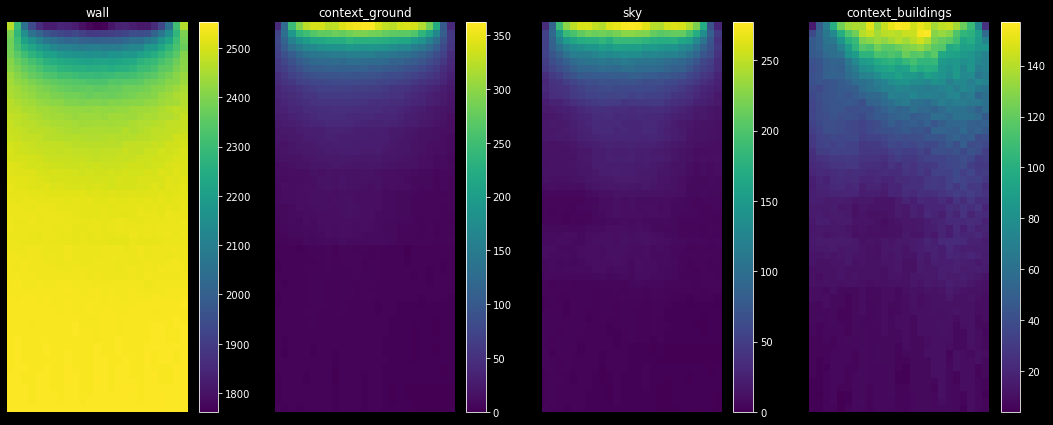

In [54]:
columns = list(view_layer_count_df.columns)
fig, axs = plt.subplots(1, len(columns), figsize=(15,6))
fig.tight_layout() 
for ax, column in zip(axs,columns):
    count_grid = np.reshape(view_layer_count_df[column].to_numpy() - 1, (-1, 25))
    pcm =ax.pcolormesh(np.flip(count_grid))
    ax.axis('off')
    ax.set_title(column)
    fig.colorbar(pcm, ax=ax, orientation="vertical", pad=0.05)

plot_path = os.path.join('plots', project_name + '_all_layers.eps')
plt.savefig(plot_path, format='eps')
# cbar = fig.colorbar()              
# cbar.set_ticks([1,2,3,4])

### 2.5. View layer count with different thresholds

In [15]:
through_win_ratio = view_layer_count_df.to_numpy() / view_layer_count_df.to_numpy().sum(axis=1).reshape(-1, 1)
through_win_ratio

array([[0.96057767, 0.01678376, 0.01209992, 0.01053864],
       [0.90241998, 0.03981265, 0.02810304, 0.02966432],
       [0.80444965, 0.08665105, 0.06674473, 0.04215457],
       ...,
       [0.9941452 , 0.00156128, 0.00156128, 0.00273224],
       [0.99492584, 0.00117096, 0.00156128, 0.00234192],
       [0.9941452 , 0.00156128, 0.0019516 , 0.00234192]])

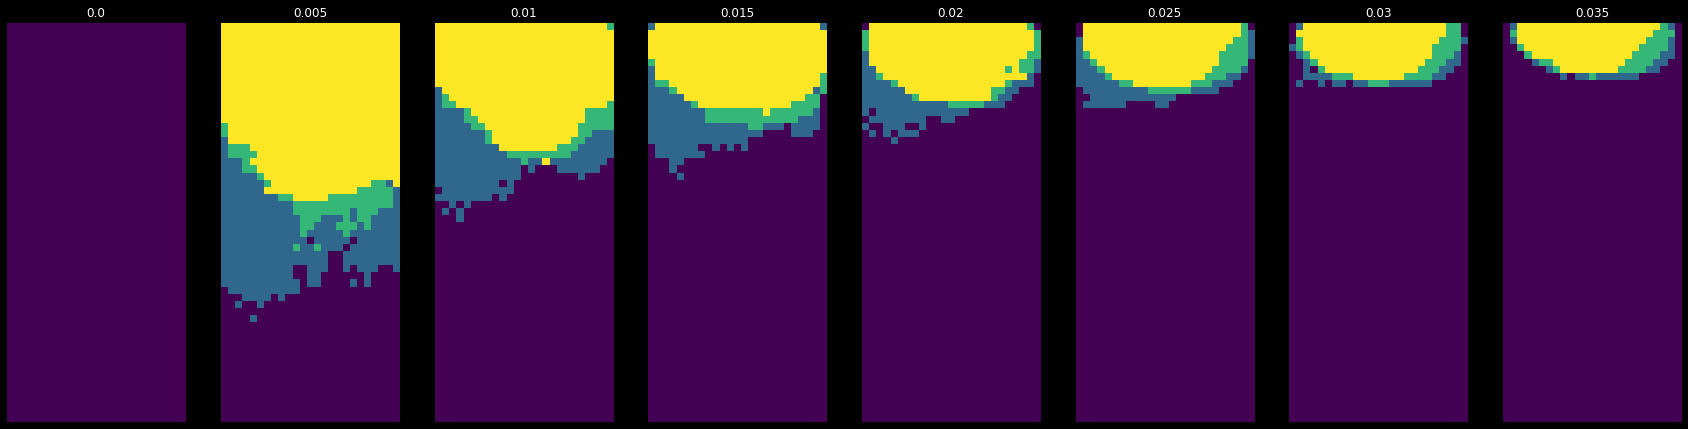

In [56]:
div = 200.0
plot_count = 8
fig, axs = plt.subplots(1, plot_count, figsize=(30,8))
for ax, t in zip(axs,range(0,plot_count)):
    count_grid = np.reshape((through_win_ratio > t/div).sum(axis=1), (-1, 25))
    ax.imshow(count_grid)
    ax.axis('off')
    ax.set_title(t/div)

plot_path = os.path.join('plots', project_name + '_view_layer_threshold.eps')
plt.savefig(plot_path, format='eps')